In [15]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS, TDC_TO_METRIC
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import SUPPORTED_BASELINES
from mood.metrics import get_metric_direction
from mood.utils import get_outlier_bounds

In [16]:
SUBDIR = "20221123_NB02"

In [17]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [14]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, SUPPORTED_BASELINES, MOOD_REPRESENTATIONS))
assert list(all_triplets) == len(paths), find_missing(paths, all_triplets)

AssertionError: Missing 6:
('CYPP4502C9', 'GP', 'Desc2D')
('CYPP4502C9', 'GP', 'ECFP6')
('CYPP4502C9', 'GP', 'MACCS')
('CYPP4502C9', 'GP', 'WHIM')
('Lipophilicity', 'GP', 'ECFP6')
('Lipophilicity', 'RF', 'ECFP6')


In [ ]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)

In [6]:
df_original[["iid_score", "ood_score"]].describe()

,iid_score,ood_score
count,126.000000,126.000000
mean,1.501783,1.636108
std,2.702473,3.223253
min,0.068997,0.065976
25%,0.472606,0.472945
50%,0.744607,0.695014
75%,0.848497,0.823541
max,11.663214,15.133435


In [7]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

df["metric_direction"] = df["metric"].apply(get_metric_direction)
df.loc[df["gap"] == "minimize", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "minimize", "relative_gap"] = -df["relative_gap"]

df["Dataset"] = df.apply(lambda x: f"{x['dataset']}\n({x['metric']})", axis=1)
df = df.rename(columns={"representation": "Representation"})
df.head()

,dataset,algorithm,Representation,iid_score,ood_score,metric,gap,relative_gap,metric_direction,Dataset
0,BBB,GP,Desc2D,0.812914,0.820601,AUROC,0.007687,0.945563,maximize,BBB\n(AUROC)
1,BBB,GP,ECFP6,0.787993,0.607826,AUROC,-0.180167,-22.864050,maximize,BBB\n(AUROC)
2,BBB,GP,MACCS,0.800296,0.738982,AUROC,-0.061314,-7.661431,maximize,BBB\n(AUROC)
3,BBB,GP,WHIM,0.617338,0.604187,AUROC,-0.013151,-2.130275,maximize,BBB\n(AUROC)
4,BBB,MLP,Desc2D,0.826842,0.827936,AUROC,0.001094,0.132273,maximize,BBB\n(AUROC)


<AxesSubplot: xlabel='relative_gap'>

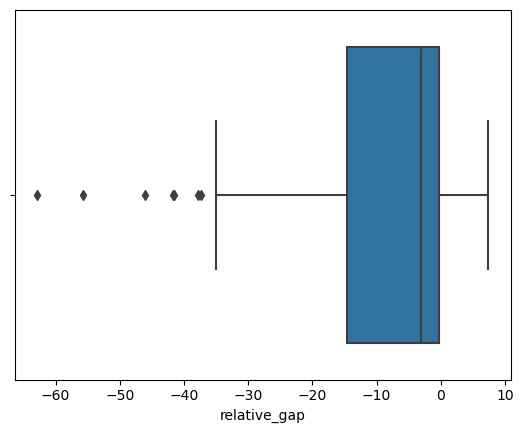

In [8]:
sns.boxplot(data=df, x="relative_gap")

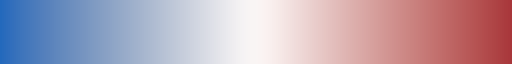

In [9]:
cmap = sns.color_palette("vlag", as_cmap=True)
cmap

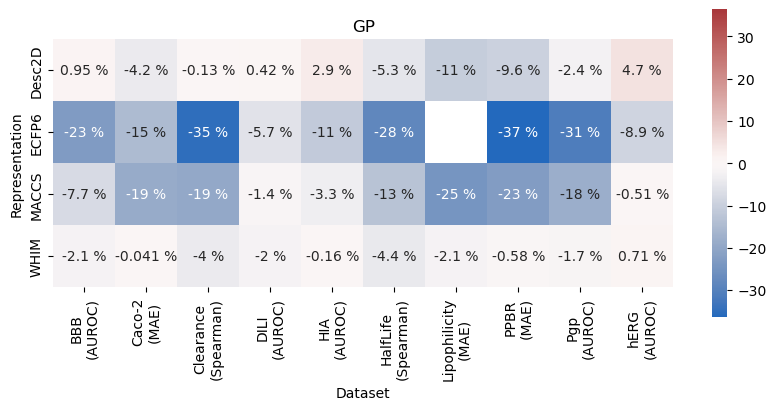

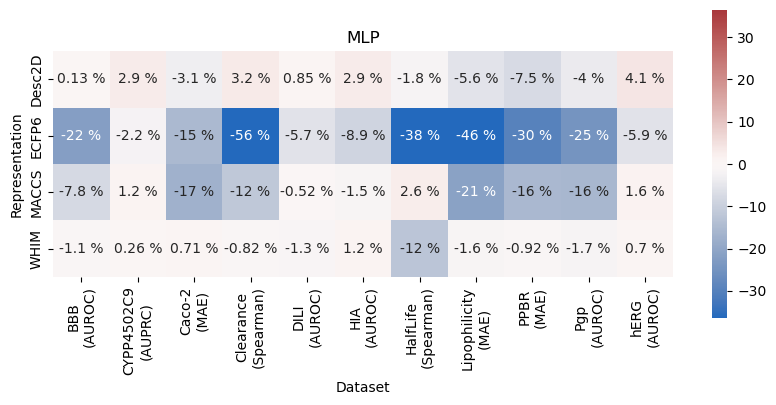

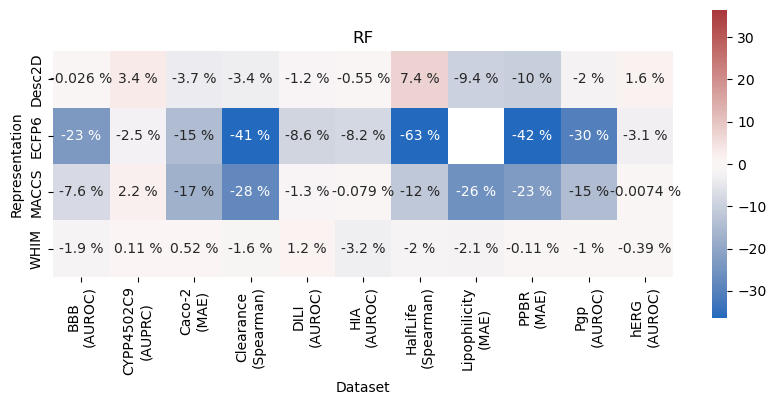

In [10]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for idx, (name, group) in enumerate(df.groupby("algorithm")):
    fig, ax = plt.subplots(figsize=(10, 4))
    pivot = group.pivot("Representation", "Dataset", metric)
    sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, square=True)
    for t in ax.texts: t.set_text(t.get_text() + " %")
    ax.set_title(name)

The End.